# CNN with a loya2Vec Embeddings

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from gensim import utils
import pandas as pd
import pickle
from random import sample
from sklearn.metrics.pairwise import cosine_similarity

## Compute custom Word2Vec embeddings

In [3]:
NUM_WORDS = 33000
MAXLEN = 5000
DIMS = 300
NGRAM_RANGE = 1

### Functions to do the heavy lifting

In [4]:
def preprocess_corpus(corpus_path, text_column='contents', max_features=33000, maxlen=5000, class_names=[0,1]):
    """
    Takes a corpus of texts stored in a csv file and processes them
    through ktrain's preprocessor in preparation for using them in
    gensim's Word2Vec model.
    """
    preproc = ktrain.text.preprocessor.StandardTextPreprocessor(max_features=max_features,
                                                                maxlen=maxlen,
                                                                class_names=class_names)
    full_corpus = pd.read_csv(corpus_path)
    full_corpus_text = full_corpus[text_column]
    dummy_labels = np.zeros(len(full_corpus_text))
    X, dummy_y = preproc.preprocess_train(full_corpus_text, dummy_labels)
    X = list(X)
    corpus = [preproc.undo(doc).split(' ') for doc in X]
    return preproc, corpus


def build_wv_model(corpus, dims, save_path=None, workers=8):
    """
    Builds, returns, and saves the Word2Vec-like model developed
    from the corpus returned by preprocess_corpus.
    """
    WV = Word2Vec(sentences=corpus, size=dims, workers=8)
    vocab = WV.wv.index2word
    vocab_len = len(vocab)
    embeddings = np.array([WV.wv.get_vector(word) for word in vocab])
    text_to_token = {word: i for word, i in zip(vocab, range(vocab_len))}
    token_to_text = {i: word for word, i in zip(vocab, range(vocab_len))}
    model = {'embeddings': embeddings,
             'text_to_token': text_to_token,
             'token_to_text': token_to_text,
             'vocab': vocab,
             'vocab_len': len(vocab)}
    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump(model, f)
    return model


def embed_word(word, wv_model, dims):
    if word in wv_model['vocab']:
        token = wv_model['text_to_token'][word]
        return wv_model['embeddings'][token]
    else:
        return np.zeros(dims)
    

def build_embeddings(preproc, wv_model, dims):
    preproc_vocab = preproc.undo(range(NUM_WORDS)).split(' ')
    Embeddings = [embed_word(word, wv_model, dims) for word in preproc_vocab]
    Embeddings = np.stack(Embeddings)
    return(Embeddings)

## Preprocess the full 13K document corpus using the ktrain preprocessor - This takes some time

Using the ktrain preprocessor on the front end ensures that the tokens that are fed to GENSIM to create the embeddings are as close to the same as will be used as input to the model as possible.

In [5]:
%%time
preproc, corpus = preprocess_corpus('../data/ICAAD_FIJI.csv', max_features=NUM_WORDS, maxlen=MAXLEN)

language: en
Word Counts: 132011
Nrows: 13384
13384 train sequences
train sequence lengths:
	mean : 2218
	95percentile : 5989
	99percentile : 11259
x_train shape: (13384,5000)
y_train shape: (13384, 1)
Is Multi-Label? False
CPU times: user 5min 23s, sys: 2.63 s, total: 5min 26s
Wall time: 5min 26s


In [6]:
%%time
wv_model = build_wv_model(corpus, DIMS, save_path='./loya2Vec/loya2Vec.pickle')

CPU times: user 9min 49s, sys: 2.89 s, total: 9min 52s
Wall time: 1min 58s


In [7]:
%%time
Embeddings = build_embeddings(preproc, wv_model, DIMS)

CPU times: user 21.5 s, sys: 24 ms, total: 21.5 s
Wall time: 21.5 s


90% of the challenge here is to map the embeddings properly between the Word2Vec model and the ktrain preprocessor.  The following is currently necessary, but is likely patching an error above.

In [8]:
model_Embeddings = np.zeros(Embeddings.shape)

for i in range(33000):
    proc_word = preproc.tok.sequences_to_texts([[i]])
    try:
        wv_token = wv_model['text_to_token'][proc_word[0]]
        model_Embeddings[i] = wv_model['embeddings'][wv_token]
    except:
        pass

## Inspect the embeddings

In [9]:
def closest_neighbors(embedding_model, text):
    """
    Takes a trained embedding model and input text and returns
    the closest five neighbors to the text in the model.
    """
    text_token = embedding_model['text_to_token'][text]
    closest_embeddings = cosine_similarity(embedding_model['embeddings'][text_token].reshape(1,-1),
                                           embedding_model['embeddings']).argsort()
    print(closest_embeddings)
    return [embedding_model['token_to_text'][token] for token in closest_embeddings[0][-5:]]

In [10]:
def closest_neighbors(preproc, embeddings, text):
    """
    Takes a trained embedding model and input text and returns
    the closest five neighbors to the text in the model.
    """
    text_token = preproc.tok.texts_to_sequences([text])[0][0]
    closest_embeddings = cosine_similarity(embeddings[text_token].reshape(1,-1),
                                           embeddings).argsort()
    print(closest_embeddings)
    return [preproc.tok.sequences_to_texts([[token]]) for token in closest_embeddings[0][-5:]]

Check that the embeddings are functioning properly.  Yes, feeding this thing English profanity returns Fijian profanity.  I have arrived as a data scientist.

In [11]:
closest_neighbors(preproc, model_Embeddings, 'breadwinner')

[[1780 6530 2986 ... 5100 6510 5271]]


[['eldest'], ['ilisavani'], ['bread'], ['winner'], ['breadwinner']]

In [12]:
closest_neighbors(preproc, model_Embeddings, 'suva')

[[ 934   18 3623 ...  386  769  128]]


[['nasinu'], ['nausori'], ['lautoka'], ['labasa'], ['suva']]

In [13]:
closest_neighbors(preproc, model_Embeddings, 'victim')

[[19214 14388 13032 ...  2724   324   394]]


[["complainant's"], ['girl'], ["victim's"], ['complainant'], ['victim']]

In [14]:
closest_neighbors(preproc, model_Embeddings, 'sydney')

[[2801  175   96 ... 6275 8920 3821]]


[['auckland'], ['perth'], ['melbourne'], ['brisbane'], ['sydney']]

## Load the training and validation sets

In [15]:
Train = pd.read_csv('../data/train_80_10_10.csv')
x_train = Train.cleaned_contents
y_train = Train.Discrimination_Label

Test = pd.read_csv('../data/val_80_10_10.csv')
x_test = Test.cleaned_contents
y_test = Test.Discrimination_Label

In [16]:
train = preproc.preprocess_test(x_train, y_train)
test = preproc.preprocess_test(x_test, y_test)

647 test sequences
test sequence lengths:
	mean : 1491
	95percentile : 3900
	99percentile : 7614
x_test shape: (647,5000)
y_test shape: (647, 2)
81 test sequences
test sequence lengths:
	mean : 1514
	95percentile : 4159
	99percentile : 5506
x_test shape: (81,5000)
y_test shape: (81, 2)


## Build the model

In [17]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               embeddings, dropout=0.1, density=64,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=False)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(density, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    
    model.layers[1].set_weights([embeddings])
    
    return model

In [18]:
model = _build_cnn(MAXLEN, len(model_Embeddings), DIMS, filters=32, kernels=[2, 3, 4, 5, 6], embeddings=model_Embeddings, dropout=0.4, density=64)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [19]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 300)    9899700     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     19232       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     28832       embedding[0][0]                  
______________________________________________________________________________________________

## Make sure the pre-trained embeddings are in place, fixed, and functioning properly in the model

In [20]:
((learner.model.layers[1].weights[0].numpy() == model_Embeddings) - 1).sum() == 0

True

In [21]:
model.layers[1].trainable

False

In [22]:
embedding_output = tf.keras.backend.function(model.layers[0].input, model.layers[1].output)

In [23]:
first_doc = train[0][1]

In [24]:
first_doc[4600:4610]

array([104,   1, 186,  32, 674,   3, 251,  80, 743, 513], dtype=int32)

In [25]:
preproc.tok.sequences_to_texts([[104,   1, 186,  32, 674,   3, 251,  80, 743, 513]])

['whether the parties are known to each other • considering']

In [26]:
((embedding_output([[104]]) == model_Embeddings[104]) - 1).sum() == 0

True

This is a fairly long winded way to get to yes, but getting the embeddings to map properly between gensim and ktrain was a serious pain point.

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/10
647/647 [==============================] - 5s 8ms/sample - loss: 3.3090 - accuracy: 0.4714
Epoch 2/10
647/647 [==============================] - 3s 4ms/sample - loss: 3.1023 - accuracy: 0.4838
Epoch 3/10
647/647 [==============================] - 3s 4ms/sample - loss: 3.1639 - accuracy: 0.4776
Epoch 4/10
647/647 [==============================] - 3s 4ms/sample - loss: 2.8976 - accuracy: 0.4730
Epoch 5/10
647/647 [==============================] - 3s 4ms/sample - loss: 1.5085 - accuracy: 0.5703
Epoch 6/10
647/647 [==============================] - 3s 4ms/sample - loss: 0.6921 - accuracy: 0.6167
Epoch 7/10
647/647 [==============================] - 3s 4ms/sample - loss: 2.6796 - accuracy: 0.5425
Epoch 8/10
647/647 [==============================] - 3s 5ms/sample - loss: 5.1054 - accuracy: 0.5688
Epoch 9/10
647/647 [==============================] - 3s 4ms/sample - loss: 7.05

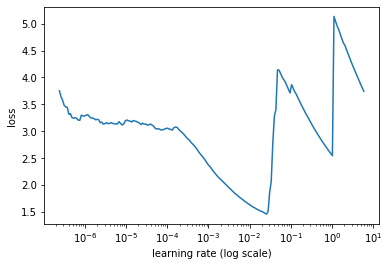

In [27]:
learner.lr_find(show_plot=True, max_epochs=10)

### Train

In [28]:
learner.autofit(10e-4, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 5s 7ms/sample - loss: 2.0475 - accuracy: 0.5301 - val_loss: 0.8105 - val_accuracy: 0.4815
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.7684 - accuracy: 0.6074 - val_loss: 0.7096 - val_accuracy: 0.5062
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6144 - accuracy: 0.6801 - val_loss: 0.6642 - val_accuracy: 0.6420
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5863 - accuracy: 0.6754 - val_loss: 0.6732 - val_accuracy: 0.5926
Epoch 5/1024
640/647 [============================>.] - ETA: 0s - loss: 0.5612 - accuracy: 0.7016
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
647/647 [==============================] - 3s 5m

## Examine results

In [29]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.75      0.18      0.29        33
           1       0.63      0.96      0.76        48

    accuracy                           0.64        81
   macro avg       0.69      0.57      0.53        81
weighted avg       0.68      0.64      0.57        81



array([[ 6, 27],
       [ 2, 46]])

## Explain a prediction

In [30]:
import pandas as pd
X_test = pd.read_csv('../data/test_80_10_10.csv')['cleaned_contents']

In [31]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [32]:
y_hat = predictor.predict(list(x_test))

In [35]:
predictor.explain('As the accused is the sole breadwinner for his family, I reduce his sentence by two years.')

In [34]:
learner.evaluate(test)

              precision    recall  f1-score   support

           0       0.75      0.18      0.29        33
           1       0.63      0.96      0.76        48

    accuracy                           0.64        81
   macro avg       0.69      0.57      0.53        81
weighted avg       0.68      0.64      0.57        81



array([[ 6, 27],
       [ 2, 46]])